In [18]:
# ####### Statistics Script 3/14 Version (works with dset v1 or dset v2)
from ovarian_utils import MetaPolygon
import numpy as np
import pandas as pd
from ovarian_utils import read_qupath_json
from shapely.strtree import STRtree
from shapely.geometry import mapping
from pathlib import Path
import json

In [19]:
def write_qupath_noIDs_Polys(xmlsave, regions, region_labels, region_colors):
    trythis = '['
    if len(regions) == 0:
        pass
    else:
        for i in range(0, len(regions)):
            roi = regions[i]
            label = region_labels[i]
            trythis += json.dumps(
                {"type": "Feature", "id": "PathAnnotationObject", "geometry": mapping(roi),
                 "properties": {"classification": {"name": label + '_'+str(i), "colorRGB": region_colors[label]}, "isLocked": False,
                                "measurements": []}}, indent=4)
            if i < len(regions) - 1:
                trythis += ','

    trythis += ']'

    with open(xmlsave, 'w') as outfile:
        outfile.write(trythis) 

In [20]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 140

In [21]:
# train list:
# file_list = ['17118416', '17118483', '17118873', '17118922', '17119598', '17122090', '17122178', '17122189', '17122204', '17122207', '17122313', '17124767', '17126247', '17126281', '17126430', '17126465', '17126513', '17133040', '17133223', '17133268', '17133434', '17133461', '17133587', '17133626', '17133630', '17133678', '17133780', '17133781', '17133792', '17133937', '17133968', '17134444', '17134545', '17134750']
# file_list = ['17133943'] # this is a training slide
# file_list = ['17121975', '17122241', '17133388', '17133503', '17133754', '17133945', '17134585'] # val
# file_list = ['17121963', '17124810', '17122321', '17133557', '17133893'] # test
master = ['17121963', '17124810', '17122321', '17133557', '17133893','17121975', '17122241', '17133388', '17133503', '17133754', '17133945', '17134585']

# master = ['17121975', '17122241', '17133388', '17133503', '17133754', '17133945', '17134585','17121963', '17124810', '17122321', '17133557', '17133893'] # val and test


In [22]:
gt_json_dir = 'GT_json_annotations/'
ai_pred_dir = 'jsons_val-test/merged_segm_bbox_jsons/'
# ai_pred_dir = 'jsons_val-test/'


Working on 17121963
jsons_val-test/merged_segm_bbox_jsons/17121963.json
gt 10 ai 12


/media/14TB/aarlova_ovarian/ovarian_utils.py:23: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  self.label = label
/media/14TB/aarlova_ovarian/ovarian_utils.py:24: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  self.id = id


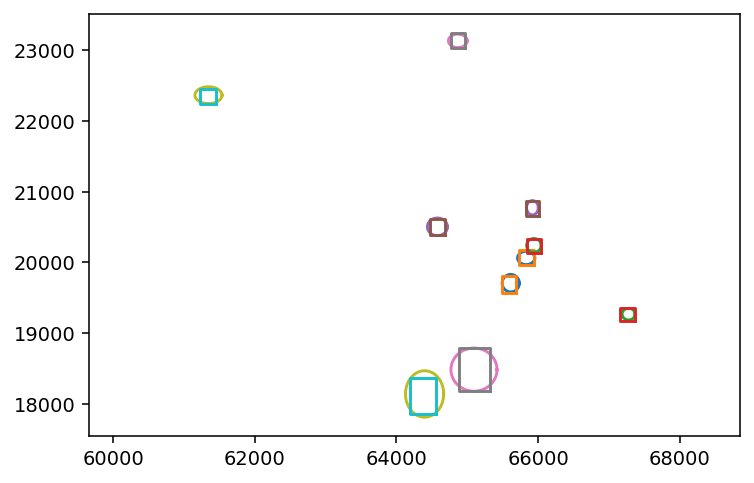

Working on 17124810
jsons_val-test/merged_segm_bbox_jsons/17124810.json
gt 36 ai 39


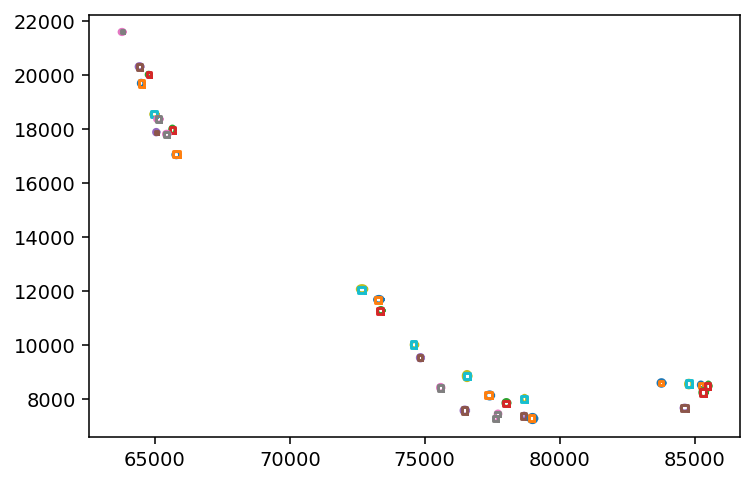

Working on 17122321
jsons_val-test/merged_segm_bbox_jsons/17122321.json
gt 1 ai 3


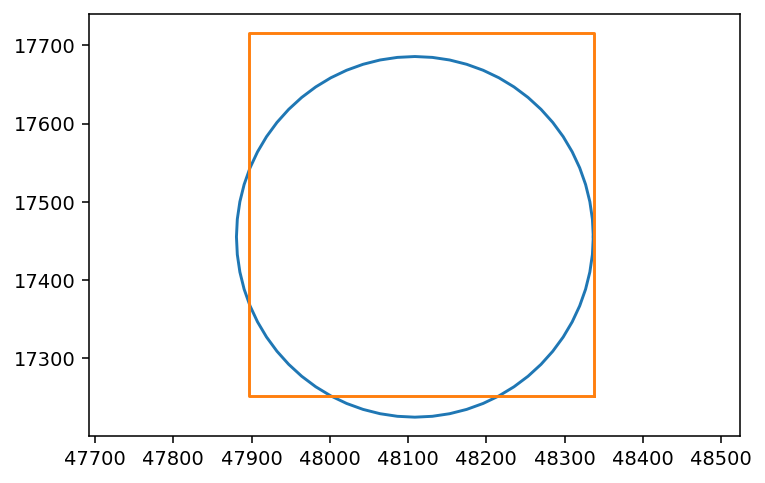

Working on 17133557
jsons_val-test/merged_segm_bbox_jsons/17133557.json
gt 126 ai 135


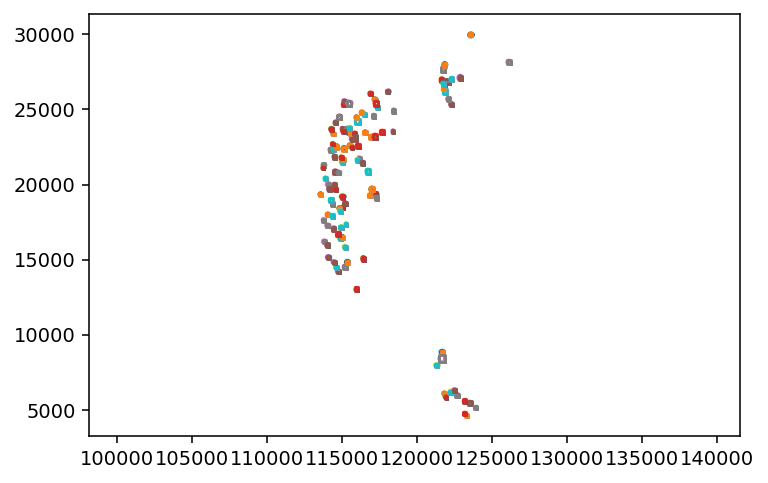

Working on 17133893
jsons_val-test/merged_segm_bbox_jsons/17133893.json
gt 81 ai 87


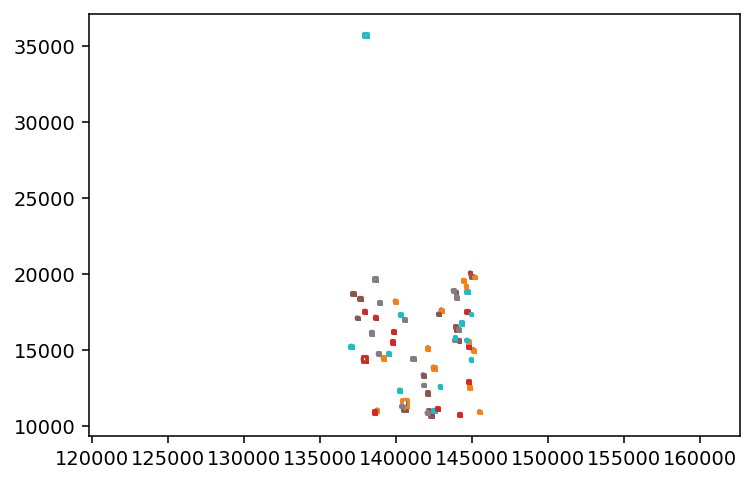

Working on 17121975
jsons_val-test/merged_segm_bbox_jsons/17121975.json
gt 10 ai 10


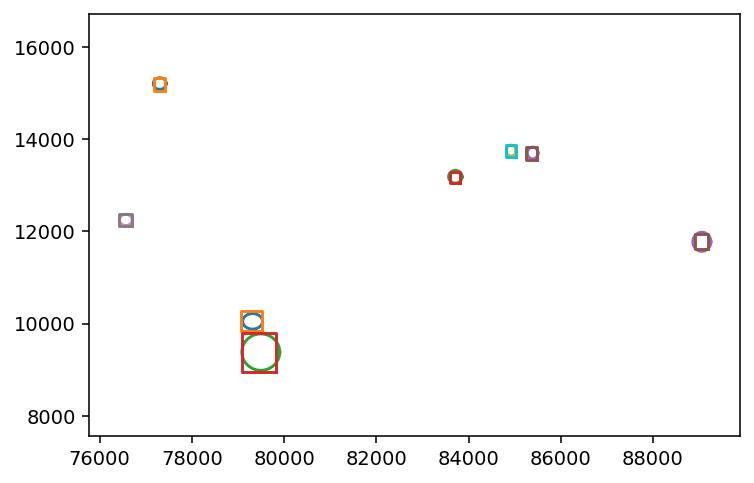

Working on 17122241
jsons_val-test/merged_segm_bbox_jsons/17122241.json
gt 32 ai 35


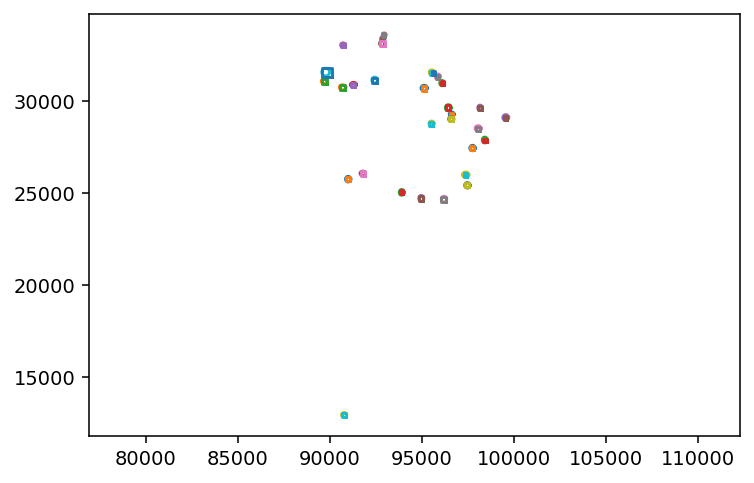

Working on 17133388
jsons_val-test/merged_segm_bbox_jsons/17133388.json
gt 47 ai 43


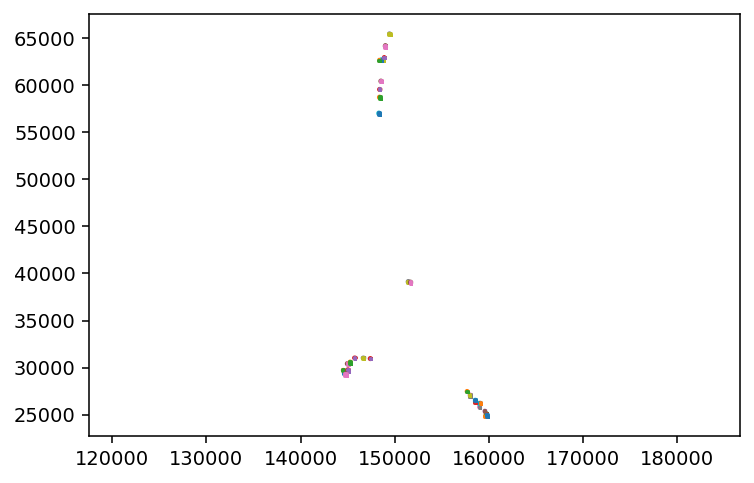

Working on 17133503
jsons_val-test/merged_segm_bbox_jsons/17133503.json
gt 126 ai 112


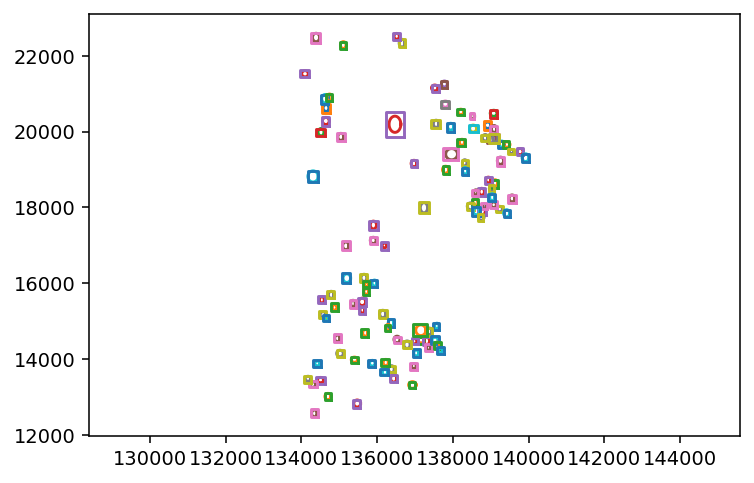

Working on 17133754
jsons_val-test/merged_segm_bbox_jsons/17133754.json
gt 131 ai 290


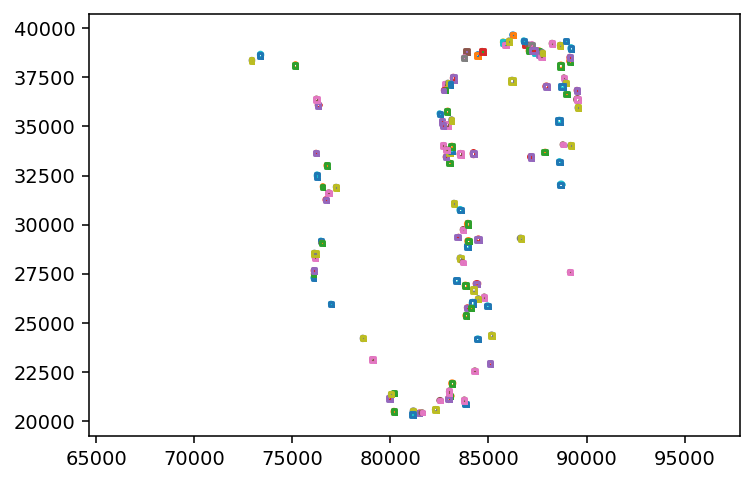

Working on 17133945
jsons_val-test/merged_segm_bbox_jsons/17133945.json
gt 307 ai 344


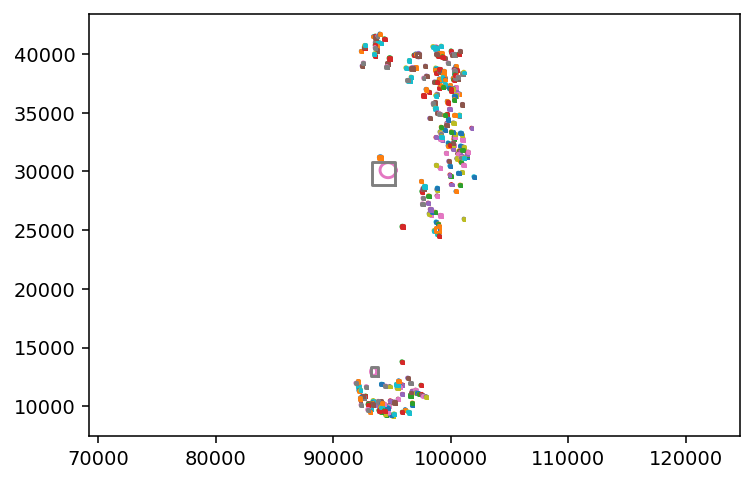

Working on 17134585
jsons_val-test/merged_segm_bbox_jsons/17134585.json
gt 6 ai 12


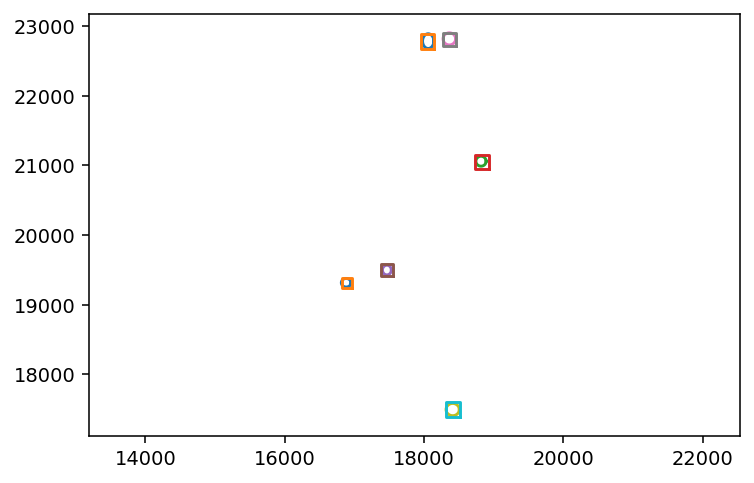

In [23]:
df_master = pd.DataFrame()
iou = []
from shapely.ops import unary_union

for i in range(len(master)):

    slide_name = master[i]

    print('Working on', slide_name)
    try:
        # read in ground truth (xml) - change to read ground truth jsons!
        gt_regions, gt_region_labels = read_qupath_json(gt_json_dir + slide_name + '.json')
    
    except:
        print('can not import gt')
        continue

    # read in AI json
    try:
        print(ai_pred_dir + slide_name + '.json')
        AI_slide_regions, AI_slide_labels = read_qupath_json(ai_pred_dir + slide_name + '.json')
    except:
        print('can not import AI')
        continue
        
    # convert gt and ai regions to MetaPolygons
    gt_polygons = []
    for i in range(len(gt_regions)):
        if gt_region_labels[i] == 'margin' or gt_region_labels[i] == 'Margin' or gt_region_labels[i] == 'Area':
            pass
        else:
            # metapoly = MetaPolygon(gt_region_labels[i], gt_regions[i])
            metapoly = MetaPolygon('Follicle', gt_regions[i])
            gt_polygons.append(metapoly)

    ai_polygons = []
    for k in range(len(AI_slide_regions)):
        metapoly = MetaPolygon(AI_slide_labels[k], AI_slide_regions[k])
        ai_polygons.append(metapoly)

    print('gt', len(gt_polygons), 'ai', len(ai_polygons))
    gt_slide_labels = np.unique([g.label for g in gt_polygons])

    # group unique labels predicted for the slide
    # AI_slide_labels = np.unique([label for label in AI_slide_labels])

    
    ######### compare GT and AI polygons:
    ######### for each GT polygon, check if it intersects with any AI polygon, and whether the class matches
    
    df_out = pd.DataFrame()

    tree = STRtree(ai_polygons)
    
    follicle_and_label_match = 0 # use this for binary, and follicle_match for multiclass seg
    # follicle_match = 0
    follicle_not_detected = 0
    
    FNs = []

    for poly in gt_polygons:
        query_geom = poly
        intersects = [o for o in tree.query(query_geom) 
                      if o.intersects(query_geom) and o.intersection(query_geom).area/unary_union([o,query_geom]).area > 0.3]
        u = [o.intersection(query_geom).area/unary_union([o,query_geom]).area for o in intersects] 
        # this is incorrect, since variable 'intersects' is an already filtered one
        iou.extend(u)
    
        if len(intersects) > 0:
            follicle_and_label_match += 1 # these are TPs
            plt.plot(*query_geom.exterior.xy)
            for inter in intersects:
                plt.plot(*inter.exterior.xy)


        else:
            follicle_not_detected += 1 # these are FNs
            FNs.append(query_geom) # collect FNs into a list
            
            
            
    plt.axis("equal")
    plt.show()
    plt.cla()
    plt.clf()
    plt.close()
    
            
    ######### compare AI and GT polygons: get FPs (false positives)
    tree2 = STRtree(gt_polygons)
    
    false_positives = []
    
    for poly in ai_polygons:
        query_geom = poly
        intersects = [o for o in tree2.query(query_geom) 
                      if o.intersects(query_geom) and o.intersection(query_geom).area/unary_union([o,query_geom]).area > 0.3]
        
        if len(intersects) == 0 and query_geom not in false_positives:
            false_positives.append(query_geom) # the query_geom from ai_polygons does not intersect with any gt_polygons and thus is a false positive

    df_out['Slide ID'] = [slide_name]
    df_out['Follicle match'] = [follicle_and_label_match] # use this for binary, and follicle_match for multiclass seg 
    df_out['Total GT follicles'] = [len(gt_polygons)]
    df_out['Total AI preds'] = [len(ai_polygons)]
    df_out['FNs/per slide'] = [follicle_not_detected]
    df_out['FPs/per slide'] = [len(false_positives)]
    if len(gt_polygons) > 0:
        df_out['Detection Rate (Sensitivity on Slide Level)'] = [follicle_and_label_match/len(gt_polygons)]
    else:
        df_out['Detection Rate (Sensitivity on Slide Level)'] = float('nan')
    df_out['PPV on slide level'] = [follicle_and_label_match/(follicle_and_label_match+len(false_positives))]

    df_master = pd.concat([df_master,df_out])

    #### write jsons for FPs and FNs
    region_colors = {'FP': -3342339}
    region_colors1 = {'FN': -12711912}
    labels_FPs = ['FP' for f in false_positives]
    labels_FNs = ['FN' for f in FNs]
    
    write_qupath_noIDs_Polys('/media/14TB/aarlova_ovarian/Failure_Analysis/merged/'+slide_name+'_FPs.json', false_positives, labels_FPs, region_colors)
    write_qupath_noIDs_Polys('/media/14TB/aarlova_ovarian/Failure_Analysis/merged/'+slide_name+'_FNs.json', FNs, labels_FNs, region_colors1)
    
    
    
    


    

In [24]:
df_master.sort_values(by='Detection Rate (Sensitivity on Slide Level)', ascending=False)


,Slide ID,Follicle match,Total GT follicles,Total AI preds,FNs/per slide,FPs/per slide,Detection Rate (Sensitivity on Slide Level),PPV on slide level
0,17121963,10,10,12,0,2,1.000000,0.833333
0,17122321,1,1,3,0,2,1.000000,0.333333
0,17134585,6,6,12,0,6,1.000000,0.500000
0,17133754,128,131,290,3,162,0.977099,0.441379
0,17122241,30,32,35,2,4,0.937500,0.882353
0,17133557,117,126,135,9,18,0.928571,0.866667
0,17133945,285,307,344,22,59,0.928339,0.828488
0,17124810,31,36,39,5,8,0.861111,0.794872
0,17133503,107,126,112,19,5,0.849206,0.955357
0,17133893,67,81,87,14,20,0.827160,0.770115


In [25]:
df_master

,Slide ID,Follicle match,Total GT follicles,Total AI preds,FNs/per slide,FPs/per slide,Detection Rate (Sensitivity on Slide Level),PPV on slide level
0,17121963,10,10,12,0,2,1.000000,0.833333
0,17124810,31,36,39,5,8,0.861111,0.794872
0,17122321,1,1,3,0,2,1.000000,0.333333
0,17133557,117,126,135,9,18,0.928571,0.866667
0,17133893,67,81,87,14,20,0.827160,0.770115
0,17121975,8,10,10,2,2,0.800000,0.800000
0,17122241,30,32,35,2,4,0.937500,0.882353
0,17133388,33,47,43,14,10,0.702128,0.767442
0,17133503,107,126,112,19,5,0.849206,0.955357
0,17133754,128,131,290,3,162,0.977099,0.441379


In [26]:
print(df_master['Detection Rate (Sensitivity on Slide Level)'].mean())

0.9009262534288934


In [27]:
stats = df_master.describe()
stats

,Follicle match,Total GT follicles,Total AI preds,FNs/per slide,FPs/per slide,Detection Rate (Sensitivity on Slide Level),PPV on slide level
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,68.583333,76.083333,93.500000,7.500000,24.833333,0.900926,0.731112
std,81.988312,87.917790,113.160787,7.891307,46.025355,0.094152,0.195100
min,1.000000,1.000000,3.000000,0.000000,2.000000,0.702128,0.333333
25%,9.500000,10.000000,12.000000,1.500000,3.500000,0.843695,0.700581
50%,32.000000,41.500000,41.000000,4.000000,7.000000,0.928455,0.797436
75%,109.500000,126.000000,117.750000,14.000000,18.500000,0.982824,0.841667
max,285.000000,307.000000,344.000000,22.000000,162.000000,1.000000,0.955357


In [28]:
df_master.to_csv('slide_wise_Merged_test_val_stats.csv')

In [29]:
stats.to_csv('descriptive_Merged_test_val_stats.csv')
# df_test_val.to_csv('test_val_stats.csv')

In [ ]:
print(np.mean(iou))
print(np.median(iou))
print(np.std(iou))

In [ ]:
import matplotlib.pyplot as plt

plt.hist(iou, bins=100)
plt.show()

In [ ]:
df_master_test = df_master
df_master_test

In [ ]:
import geopandas as gpd

In [ ]:
gdf = gpd.GeoDataFrame()
gdf['geometry'] = false_positives

gdf.plot()